### Video Understanding with Qwen3-VL

In this notebook, we delve into the capabilities of the **Qwen3-VL** model for video understanding tasks. Our objective is to showcase how this advanced model can be applied to various video analysis scenarios.


#### \[Setup\]

We start by loading the pre-trained `Qwen3-VL` model. 

In [ ]:
from transformers import AutoProcessor, AutoModelForVision2Seq
from qwen_vl_utils import process_vision_info
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="transformers")
import os 
import dashscope
dashscope.base_http_api_url = 'https://dashscope-intl.aliyuncs.com/compatible-mode/v1'
os.environ['DASHSCOPE_API_KEY'] = 'sk-***' # Your DashScope API Key
os.environ['OPENAI_BASE_HTTP_API_URL'] = 'https://dashscope-intl.aliyuncs.com/compatible-mode/v1'
DASH_MODEL_ID = '***' # Your model-ID for API
model_path = "***" #  The following output example is from a tiny test model
processor = AutoProcessor.from_pretrained(model_path)

model, output_loading_info = AutoModelForVision2Seq.from_pretrained(model_path, torch_dtype="auto", device_map="auto", output_loading_info=True)
print("output_loading_info", output_loading_info)

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]


output_loading_info {'missing_keys': [], 'unexpected_keys': [], 'mismatched_keys': [], 'error_msgs': []}


Load video frames and timestamps

In [5]:
import os
import math
import hashlib
import requests

from IPython.display import Markdown, display
import numpy as np
from PIL import Image
import decord
from decord import VideoReader, cpu


def download_video(url, dest_path):
    response = requests.get(url, stream=True)
    with open(dest_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8096):
            f.write(chunk)
    print(f"Video downloaded to {dest_path}")


def get_video_frames(video_path, num_frames=128, cache_dir='.cache'):
    os.makedirs(cache_dir, exist_ok=True)

    video_hash = hashlib.md5(video_path.encode('utf-8')).hexdigest()
    if video_path.startswith('http://') or video_path.startswith('https://'):
        video_file_path = os.path.join(cache_dir, f'{video_hash}.mp4')
        if not os.path.exists(video_file_path):
            download_video(video_path, video_file_path)
    else:
        video_file_path = video_path

    frames_cache_file = os.path.join(cache_dir, f'{video_hash}_{num_frames}_frames.npy')
    timestamps_cache_file = os.path.join(cache_dir, f'{video_hash}_{num_frames}_timestamps.npy')

    if os.path.exists(frames_cache_file) and os.path.exists(timestamps_cache_file):
        frames = np.load(frames_cache_file)
        timestamps = np.load(timestamps_cache_file)
        return video_file_path, frames, timestamps

    vr = VideoReader(video_file_path, ctx=cpu(0))
    total_frames = len(vr)

    indices = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)
    frames = vr.get_batch(indices).asnumpy()
    timestamps = np.array([vr.get_frame_timestamp(idx) for idx in indices])

    np.save(frames_cache_file, frames)
    np.save(timestamps_cache_file, timestamps)
    
    return video_file_path, frames, timestamps


def create_image_grid(images, num_columns=8):
    pil_images = [Image.fromarray(image) for image in images]
    num_rows = math.ceil(len(images) / num_columns)

    img_width, img_height = pil_images[0].size
    grid_width = num_columns * img_width
    grid_height = num_rows * img_height
    grid_image = Image.new('RGB', (grid_width, grid_height))

    for idx, image in enumerate(pil_images):
        row_idx = idx // num_columns
        col_idx = idx % num_columns
        position = (col_idx * img_width, row_idx * img_height)
        grid_image.paste(image, position)

    return grid_image


Inference function

In [6]:
def inference(video, prompt, max_new_tokens=2048, total_pixels=20480 * 32 * 32, min_pixels=64 * 32 * 32, max_frames= 2048, sample_fps = 2):
    """
    Perform multimodal inference on input video and text prompt to generate model response.

    Args:
        video (str or list/tuple): Video input, supports two formats:
            - str: Path or URL to a video file. The function will automatically read and sample frames.
            - list/tuple: Pre-sampled list of video frames (PIL.Image or url). 
              In this case, `sample_fps` indicates the frame rate at which these frames were sampled from the original video.
        prompt (str): User text prompt to guide the model's generation.
        max_new_tokens (int, optional): Maximum number of tokens to generate. Default is 2048.
        total_pixels (int, optional): Maximum total pixels for video frame resizing (upper bound). Default is 20480*32*32.
        min_pixels (int, optional): Minimum total pixels for video frame resizing (lower bound). Default is 16*32*32.
        sample_fps (int, optional): ONLY effective when `video` is a list/tuple of frames!
            Specifies the original sampling frame rate (FPS) from which the frame list was extracted.
            Used for temporal alignment or normalization in the model. Default is 2.

    Returns:
        str: Generated text response from the model.

    Notes:
        - When `video` is a string (path/URL), `sample_fps` is ignored and will be overridden by the video reader backend.
        - When `video` is a frame list, `sample_fps` informs the model of the original sampling rate to help understand temporal density.
    """

    messages = [
        {"role": "user", "content": [
                {"video": video,
                "total_pixels": total_pixels, 
                "min_pixels": min_pixels, 
                "max_frames": max_frames,
                'sample_fps':sample_fps},
                {"type": "text", "text": prompt},
            ]
        },
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs, video_kwargs = process_vision_info([messages], return_video_kwargs=True, 
                                                                   image_patch_size= 16,
                                                                   return_video_metadata=True)
    if video_inputs is not None:
        video_inputs, video_metadatas = zip(*video_inputs)
        video_inputs, video_metadatas = list(video_inputs), list(video_metadatas)
    else:
        video_metadatas = None
    inputs = processor(text=[text], images=image_inputs, videos=video_inputs, video_metadata=video_metadatas, **video_kwargs, do_resize=False, return_tensors="pt")
    inputs = inputs.to('cuda')

    output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    return output_text[0]


Inference function with API using OpenAI and Dashscope SDK.

**Important Notice:**
- Video input is limited to 1 GB maximum file size.
- When using frame list format: 4–512 frames required (support for more frames coming soon).

In [7]:
import os
from openai import OpenAI
from IPython.display import Markdown, display


def inference_with_openai_api(
    video,
    prompt,
    model_id = DASH_MODEL_ID,
    video_type='url'
):
    if video_type=='url':
        video_msg = {"type": "video_url", "video_url": {"url": video}}
    elif video_type=='frame_list':
        video_msg = {"type": "video", "video": video['frame_list']}
    
    client = OpenAI(
        api_key = os.getenv('DASHSCOPE_API_KEY'),
        base_url = os.getenv('OPENAI_BASE_HTTP_API_URL'),
    )    
    messages = [
        {
            "role": "user",
            "content": [
                video_msg,
                {"type": "text", "text": prompt},
            ]
        }
    ]
    completion = client.chat.completions.create(
        model = model_id,
        messages = messages,
    )
    print(completion)
    return completion.choices[0].message.content


def inference_with_dashscope_api(
    video,
    prompt,
    model_id = DASH_MODEL_ID,
    video_type='url'
):
    if video_type=='url':
        video_msg = {"video": video}
    elif video_type=='frame_list':
        video_msg = {"video": video['frame_list'], 'fps': video['fps'] }
    
    messages = [
        {
            "role": "user",
            "content": [
                video_msg,
                {"text": prompt},
            ]
        }
    ]
    completion = dashscope.MultiModalConversation.call(
        api_key=os.getenv("DASHSCOPE_API_KEY"),
        model=model_id, 
        messages=messages
    )
    print(completion)
    return completion["output"]["choices"][0]["message"].content[0]["text"]


####  \[Usage\]

Once the model is loaded (or the API is ready), you can provide video inputs in **two formats**:

1. **Video URL (`video_url`)** — A file path or publicly accessible HTTP(S) URL pointing to a video file (e.g., MP4, AVI).  
   ✅ Best for quick prototyping or when you want the model/API to handle video decoding internally.
2. **Frame List (`frame_list`)** — A list of PIL Image objects or file paths representing sampled frames from a video.  
   ✅ Best for fine-grained control, preprocessing, or when you’ve already decoded the video.


### 1. Using Video URL - Local Inference

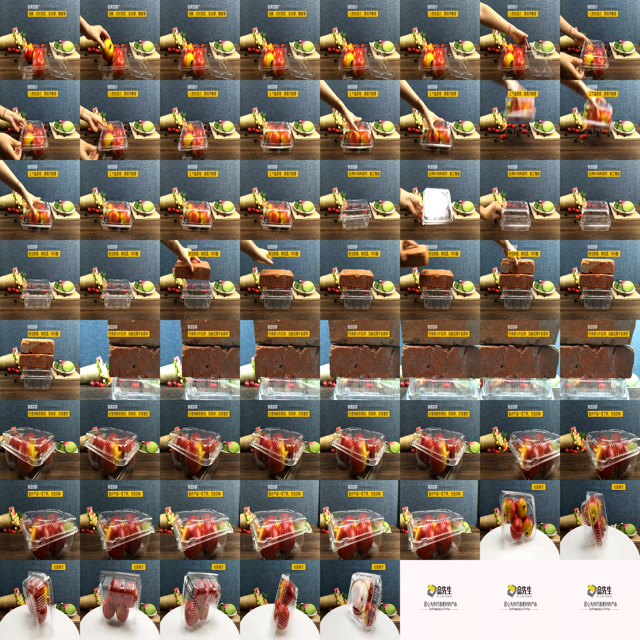

qwen-vl-utils using decord to read video.


| 特点 | 描述 |
| --- | --- |
| 适用范围广 | 龙眼、切片西瓜、圣女果、樱桃等 |
| 捏扣设计 | 人性化设计，易扣不繁琐 |
| 捏扣紧锁 | 上下盖紧锁，摇晃不脱落 |
| 专业铝膜 | 采用PET材料制作，做工精细 |
| 防压抗摔 | 耐压耐磨，耐低温，可冷藏；可承受12斤红砖，运输过程不会损坏 |
| 美观实用 | 纹理清晰质感佳，形状好，光泽度好 |
| 高透加厚 | 盒内产品一目了然，无色无味 |
| 全面展示 | 展示产品的各个角度和细节 |

In [5]:
### 1. Local Inference — Using Video URL
video_url = "https://duguang-labelling.oss-cn-shanghai.aliyuncs.com/qiansun/video_ocr/videos/50221078283.mp4"
prompt = "请用表格总结一下视频中的商品特点"

video_path, frames, timestamps = get_video_frames(video_url, num_frames=64)
image_grid = create_image_grid(frames, num_columns=8)
display(image_grid.resize((640, 640)))

response = inference(video_path, prompt)
display(Markdown(response))

### 2. Using Video URL - API Inference

In [6]:
### 2. Using Video URL - API Inference  Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1

video_url = "https://ofasys-multimodal-wlcb-3.oss-cn-wulanchabu.aliyuncs.com/sibo.ssb/datasets/cookbook/ead2e3f0e7f836c9ec51236befdaf2d843ac13a6.mp4"
prompt = "Localize a series of activity events in the video, output the start and end timestamp for each event, and describe each event with sentences. Provide the result in json format with 'mm:ss.ff' format for time depiction."

# You can also perform inference using the OpenAI-compatible format, but some parameters (e.g., FPS) cannot be passed through. 
# response = inference_with_openai_api(video_url, prompt) 
# Some parameters (e.g., `total_pixels`, `max_frames`) are not yet supported — we will add them soon.
response = inference_with_dashscope_api(video_url, prompt)
display(Markdown(response))

{"status_code": 200, "request_id": "3da7fecf-8bbb-4c68-8964-879794d3e761", "code": "", "message": "", "output": {"text": null, "finish_reason": null, "choices": [{"finish_reason": "stop", "message": {"role": "assistant", "content": [{"text": "{\n    \"00:23.00 - 00:48.00\": \"trim the fat off a piece of beef.\",\n    \"00:56.00 - 01:28.00\": \"season the beef with salt and pepper.\",\n    \"01:29.00 - 01:38.00\": \"place the beef on a grill and close the lid.\",\n    \"01:40.00 - 02:02.00\": \"add oil chopped onions carrots and squash to a pot and stir.\",\n    \"02:02.00 - 02:08.00\": \"place a rack in the pot.\",\n    \"02:09.00 - 02:14.00\": \"place the beef on the rack.\",\n    \"02:19.00 - 02:30.00\": \"pour beer into the pot.\",\n    \"02:33.00 - 02:40.00\": \"place the lid on the pot and place hot coals on top of the lid.\",\n    \"03:15.00 - 03:20.00\": \"slice the beef against the grain.\"\n}"}]}}]}, "usage": {"input_tokens": 64572, "output_tokens": 286, "input_tokens_details"

{
    "00:23.00 - 00:48.00": "trim the fat off a piece of beef.",
    "00:56.00 - 01:28.00": "season the beef with salt and pepper.",
    "01:29.00 - 01:38.00": "place the beef on a grill and close the lid.",
    "01:40.00 - 02:02.00": "add oil chopped onions carrots and squash to a pot and stir.",
    "02:02.00 - 02:08.00": "place a rack in the pot.",
    "02:09.00 - 02:14.00": "place the beef on the rack.",
    "02:19.00 - 02:30.00": "pour beer into the pot.",
    "02:33.00 - 02:40.00": "place the lid on the pot and place hot coals on top of the lid.",
    "03:15.00 - 03:20.00": "slice the beef against the grain."
}

### 3. Using Frame List — Local Inference 

In [8]:
## 3. API Inference — Using Video URL  Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# Base URL for pre-extracted video frames (public OSS bucket)
video_frame_dir = 'https://ofasys-multimodal-wlcb-3-toshanghai.oss-cn-shanghai.aliyuncs.com/Qwen3VL/demo/video/demo_cooking'

# Configure sampling: e.g., 0.25 FPS = 1 frame per 4 seconds
sample_fps=0.25 # or =1 

# The maximum number of pixels expected to be used from the video — adjustable based on available GPU memory. Our model natively supports up to 256K input tokens.
total_pixels=24*1024*32*32   # or 256*1024*32*32 

video_frame_list = [f"{video_frame_dir}/{i}.000.jpg" for i in range(0, 1228, int(1/sample_fps))]
prompt = "Briefly describe the video."
response = inference(video_frame_list, prompt, sample_fps=sample_fps, total_pixels=total_pixels)
display(Markdown(response)) 

A woman in a kitchen prepares and cooks a dish of meat, onions, and cheese wrapped in dough, which she then fries until golden brown. The final product is served with ketchup and garnished with parsley.

### 4. Using Frame List — API Inference 

In [9]:
## 4. API Inference — Using Video URL  Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
video_frame_list = [f"https://ofasys-multimodal-wlcb-3-toshanghai.oss-cn-shanghai.aliyuncs.com/Qwen3VL/demo/video/validation_Math_6/{i}.000.jpg" for i in range(0, 302, 2)]

video = {
        'frame_list':video_frame_list,
        'fps': '0.5'
    }
# fps
prompt = "Describe this video."

response = inference_with_dashscope_api(video, prompt, video_type='frame_list')
display(Markdown(response))

{"status_code": 200, "request_id": "941175ee-7384-49ca-80a9-83f93642b000", "code": "", "message": "", "output": {"text": null, "finish_reason": null, "choices": [{"finish_reason": "stop", "message": {"role": "assistant", "content": [{"text": "The video shows a person solving a geometry problem involving a circle and a right triangle. The goal is to find the length of an unknown segment, marked with a question mark, which is part of a tangent line from an external point to the circle.\n\nThe person begins by identifying the key geometric property: a radius is perpendicular to a tangent line at the point of tangency. This creates a right triangle, allowing the use of the Pythagorean Theorem (C² = A² + B²).\n\nThe triangle’s sides are:\n- One leg: the radius, labeled as 4.\n- The other leg: the tangent segment, labeled as 4.2.\n- The hypotenuse: the line from the circle’s center to the external point, which is the sum of the radius (4) and the unknown segment (?), written as (4 + ?).\n\nT

The video shows a person solving a geometry problem involving a circle and a right triangle. The goal is to find the length of an unknown segment, marked with a question mark, which is part of a tangent line from an external point to the circle.

The person begins by identifying the key geometric property: a radius is perpendicular to a tangent line at the point of tangency. This creates a right triangle, allowing the use of the Pythagorean Theorem (C² = A² + B²).

The triangle’s sides are:
- One leg: the radius, labeled as 4.
- The other leg: the tangent segment, labeled as 4.2.
- The hypotenuse: the line from the circle’s center to the external point, which is the sum of the radius (4) and the unknown segment (?), written as (4 + ?).

The person writes the equation:  
(4 + ?)² = 4² + 4.2²

Using a calculator, they compute:
- 4² = 16
- 4.2² = 17.64
- Sum: 16 + 17.64 = 33.64

Then, they take the square root of 33.64, which equals 5.8, so:
4 + ? = 5.8

Finally, they subtract 4 from both sides to solve for the unknown:
? = 5.8 - 4 = 1.8

The video concludes with the answer: **? = 1.8 units**, written clearly on the paper and underlined for emphasis. The person gestures to confirm the solution and the geometric setup.

### 5. Using Interleaved Timestamp-Image Pairs — API Inference 

- In the following section, we will demonstrate, through a spatial-temporal grounding example, how to call the API for inference by using interleaved timestamp-image pairs as input.

In [10]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": "<0.0 seconds>"
            },
            {
                "type": "image_url",
                "image_url":
                {
                    "url": "https://ofasys-multimodal-wlcb-3-toshanghai.oss-cn-shanghai.aliyuncs.com/Qwen3VL/demo/video/VidSTG_video0908val_fps1/2588643984_frames/2588643984_frame_00000000.jpg"
                }
            },
            {
                "type": "text",
                "text": "<1.0 seconds>"
            },
            {
                "type": "image_url",
                "image_url":
                {
                    "url": "https://ofasys-multimodal-wlcb-3-toshanghai.oss-cn-shanghai.aliyuncs.com/Qwen3VL/demo/video/VidSTG_video0908val_fps1/2588643984_frames/2588643984_frame_00000030.jpg"
                }
            },
            {
                "type": "text",
                "text": "<2.0 seconds>"
            },
            {
                "type": "image_url",
                "image_url":
                {
                    "url": "https://ofasys-multimodal-wlcb-3-toshanghai.oss-cn-shanghai.aliyuncs.com/Qwen3VL/demo/video/VidSTG_video0908val_fps1/2588643984_frames/2588643984_frame_00000060.jpg"
                }
            },
            {
                "type": "text",
                "text": "<3.0 seconds>"
            },
            {
                "type": "image_url",
                "image_url":
                {
                    "url": "https://ofasys-multimodal-wlcb-3-toshanghai.oss-cn-shanghai.aliyuncs.com/Qwen3VL/demo/video/VidSTG_video0908val_fps1/2588643984_frames/2588643984_frame_00000090.jpg"
                }
            },
            {
                "type": "text",
                "text": "<4.0 seconds>"
            },
            {
                "type": "image_url",
                "image_url":
                {
                    "url": "https://ofasys-multimodal-wlcb-3-toshanghai.oss-cn-shanghai.aliyuncs.com/Qwen3VL/demo/video/VidSTG_video0908val_fps1/2588643984_frames/2588643984_frame_00000120.jpg"
                }
            },
            {
                "type": "text",
                "text": "<5.0 seconds>"
            },
            {
                "type": "image_url",
                "image_url":
                {
                    "url": "https://ofasys-multimodal-wlcb-3-toshanghai.oss-cn-shanghai.aliyuncs.com/Qwen3VL/demo/video/VidSTG_video0908val_fps1/2588643984_frames/2588643984_frame_00000150.jpg"
                }
            },
            {
                "type": "text",
                "text": "<6.0 seconds>"
            },
            {
                "type": "image_url",
                "image_url":
                {
                    "url": "https://ofasys-multimodal-wlcb-3-toshanghai.oss-cn-shanghai.aliyuncs.com/Qwen3VL/demo/video/VidSTG_video0908val_fps1/2588643984_frames/2588643984_frame_00000180.jpg"
                }
            },
            {
                "type": "text",
                "text": "<7.0 seconds>"
            },
            {
                "type": "image_url",
                "image_url":
                {
                    "url": "https://ofasys-multimodal-wlcb-3-toshanghai.oss-cn-shanghai.aliyuncs.com/Qwen3VL/demo/video/VidSTG_video0908val_fps1/2588643984_frames/2588643984_frame_00000210.jpg"
                }
            },
            {
                "type": "text",
                "text": "Given the query \"there is a moving bicycle towards an adult in black in a path.\", for each frame, detect and localize the visual content described by the given textual query in JSON format. If the visual content does not exist in a frame, skip that frame. Output Format: [{\"time\": 1.0, \"bbox_2d\": [x_min, y_min, x_max, y_max], \"label\": \"\"}, {\"time\": 2.0, \"bbox_2d\": [x_min, y_min, x_max, y_max], \"label\": \"\"}, ...]."
            }
        ]
    }
]

In [ ]:
import os
from openai import OpenAI


def inference_with_openai_api(
    model_id = DASH_MODEL_ID,
    messages = messages
):
    client = OpenAI(
        api_key = os.getenv('DASHSCOPE_API_KEY'),
        base_url = os.getenv('OPENAI_BASE_HTTP_API_URL'),
    )
    completion = client.chat.completions.create(
        model=model_id,
        messages=messages,
        seed=125,
    )
    return completion.choices[0].message.content


In [12]:
import json
import markdown
from bs4 import BeautifulSoup
from datetime import datetime
import math
from PIL import Image, ImageDraw
from io import BytesIO
import requests


# draw bbox on image
def draw_bbox(image, bbox):
    draw = ImageDraw.Draw(image)
    draw.rectangle(bbox, outline='red', width=4)
    return image


def create_image_grid_pil(pil_images, num_columns=8):
    num_rows = math.ceil(len(pil_images) / num_columns)

    img_width, img_height = pil_images[0].size
    grid_width = num_columns * img_width
    grid_height = num_rows * img_height
    grid_image = Image.new('RGB', (grid_width, grid_height))

    for idx, image in enumerate(pil_images):
        row_idx = idx // num_columns
        col_idx = idx % num_columns
        position = (col_idx * img_width, row_idx * img_height)
        grid_image.paste(image, position)

    return grid_image


def parse_json(response):
    html = markdown.markdown(response, extensions=['fenced_code'])
    soup = BeautifulSoup(html, 'html.parser')
    json_text = soup.find('code').text

    data = json.loads(json_text)
    return data


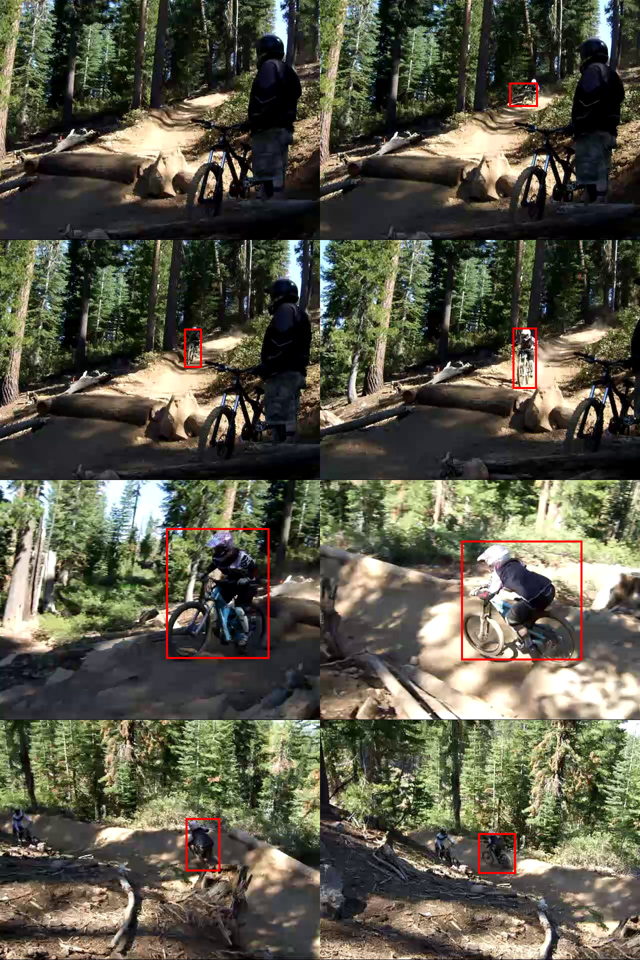

In [13]:
response = inference_with_openai_api(messages=messages)
results = parse_json(response)

vis_images = []
for content_idx, content in enumerate(messages[0]['content']):
    matched_result = None
    if content['type'] == 'text' and "seconds>" in content['text']:
        for result in results:
            time_str = str(result['time'])
            if time_str in content['text']:
                matched_result = result

        image_url = messages[0]['content'][content_idx + 1]['image_url']['url']
        image = Image.open(BytesIO(requests.get(image_url).content))

        if matched_result is not None:
            image_width, image_height = image.size
            x_min, y_min, x_max, y_max = matched_result['bbox_2d']
            x_min = x_min / 1000 * image_width
            y_min = y_min / 1000 * image_height
            x_max = x_max / 1000 * image_width
            y_max = y_max / 1000 * image_height
            image = draw_bbox(image, [x_min, y_min, x_max, y_max])
            vis_images.append(image)
        else:
            vis_images.append(image)


image_grid = create_image_grid_pil(vis_images, num_columns=2)
display(image_grid.resize((640, 960)))
